# Representation with a Feature Cross

In this exercise, you'll experiment with different ways to represent features.

https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/representation_with_a_feature_cross.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=representation_tf2-colab&hl=en

## Learning Objectives:

After doing this Colab, you'll know how to:

  * Use [`tf.feature_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column) methods to represent features in different ways.
  * Represent features as [bins](https://developers.google.com/machine-learning/glossary/#bucketing). 
  * Cross bins to create a [feature cross](https://developers.google.com/machine-learning/glossary/#feature_cross). 

## The Dataset
  
Like several of the previous Colabs, this exercise uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

## Representation
`Feature engineering` means transforming raw data into a feature vector. Many ML models require features to be represented as real-numbered vectors. For numerical raw data, we may directly copy them over into the feature vector. For categorical data, we can create a binary vector to one-hot-encode or multi-hot-encode the different categories. If there are too many categories, e.g. explicitly creating a binary vector of 1,000,000 elements where only 1 or 2 elements are true is a very inefficient representation in terms of both storage and computation time when processing these vectors. In this situation, a common approach is to use a [sparse representation](https://developers.google.com/machine-learning/glossary#sparse_representation) in which only nonzero values are stored. In sparse representations, an independent model weight is still learned for each feature value, as described above.

Now we explore what kinds of values actually make good features within those feature vectors. Some criteria for good features are:

- **Avoid rarely used discrete feature values.** Good feature values should appear more than 5 or so times in a data set.
- **Prefer clear and obvious meanings.** In some cases, noisy data (rather than bad engineering choices) causes unclear values. 
- **Don't mix "magic" values with actual data.** Good floating-point features don't contain peculiar out-of-range discontinuities or "magic" values.
    - Often missing values are represented with magic values. For discrete variables, add a new value/level to indicate missing entries. For continuous variables, we may interpolate using the mean.
- **Account for upstream instability.** The definition of a feature shouldn't change over time.

## Data normalization
`Feature scaling` is generally performed during data preprocessing. Scaling means converting floating-point feature values from their natural range (for example, 100 to 900) into a standard range (for example, 0 to 1 or -1 to +1). If a feature set consists of multiple features, then feature scaling provides the following benefits:

1. Helps gradient descent converge more quickly.
2. Helps avoid the "NaN trap", in which one number in the model becomes a `NaN` (e.g., when a value exceeds the floating-point precision limit during training), and — due to math operations — every other number in the model also eventually becomes a NaN.
3. Helps the model learn appropriate weights for each feature. Without feature scaling, the model will pay too much attention to the features having a wider range.

A popular method for scaling is to calculate the `z-score`:

$$
\text{z-score} = \frac{X - \mu}{\sigma}
$$

where $\mu$ is the sample mean and $\sigma$ is the standard deviation. Most z-scores would be between -3 and 3.

The influence of extreme `outliers` could be minimized by taking the log of every value (using the `roomsPerPerson` variable as an example). If the log-scaled values still have a long tail, we may `clip` the feature at an arbitrary value, e.g. 4.0. Despite the artifact at 4.0, the feature is still more useful than the original data.

For certain continuous variables where no obvious linear relationship exists between it and the label (e.g. `latitude`), we may divide it into `bins` to make it into a helpful predictor. This converts the continuous variable to a discrete variable.

## Data scrubbing
Until now, we've assumed that all the data used for training and testing was trustworthy. In real-life, many examples in data sets are unreliable due to one or more of the following:

- Omitted values. For instance, a person forgot to enter a value for a house's age.
- Duplicate examples. For example, a server mistakenly uploaded the same logs twice.
- Bad labels. For instance, a person mislabeled a picture of an oak tree as a maple.
- Bad feature values. For example, someone typed in an extra digit, or a thermometer was left out in the sun.

Once detected, you typically "fix" bad examples by removing them from the data set. To detect omitted values or duplicated examples, you can write a simple program. Detecting bad feature values or labels can be far trickier.

In addition to detecting bad individual examples, you must also detect bad data in the aggregate. Histograms are a great mechanism for visualizing your data in the aggregate. In addition, getting statistics like the following can help:

- Maximum and minimum
- Mean and median
- Standard deviation

> Read [this post](https://developers.google.com/machine-learning/guides/rules-of-ml/#ml_phase_ii_feature_engineering) for more information on feature engineering.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

In [2]:
# Load data
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Scale the label to median house value in k$
train_df["median_house_value"] /= 1000.0
test_df["median_house_value"] /= 1000.0

# Shuffle the training set
shuffled_train_df = (train_df
                     .sample(frac=1, random_state=42)
                     .reset_index(drop=True))

/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

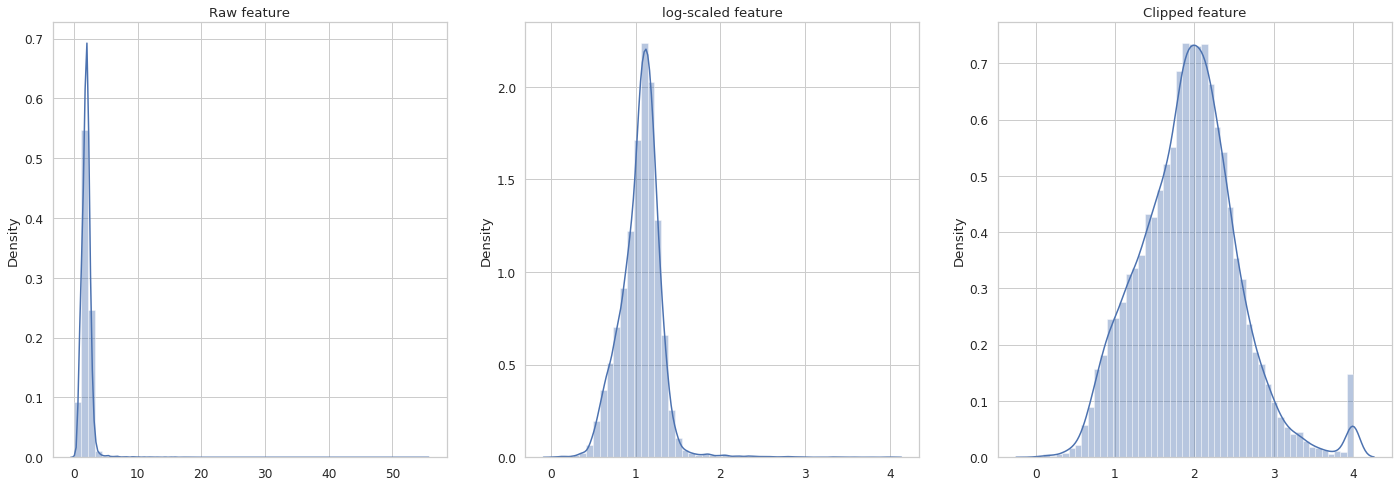

In [3]:
roomsPerPerson = train_df["total_rooms"] / train_df["population"]

fig, ax = plt.subplots(1, 3, figsize=(24, 8))
sns.distplot(roomsPerPerson, ax=ax[0])
ax[0].set_title("Raw feature")

logRoomsPerPerson = np.log(roomsPerPerson + 1)
sns.distplot(logRoomsPerPerson, ax=ax[1])
ax[1].set_title("log-scaled feature")

roomsPerPersonClipped = np.where(roomsPerPerson > 4.0, 4.0, roomsPerPerson)
sns.distplot(roomsPerPersonClipped, ax=ax[2])
ax[2].set_title("Clipped feature")

fig.show()

## Feature crosses
A `feature cross` is a synthetic feature formed by multiplying (crossing) two or more features. Crossing combinations of features can provide predictive abilities beyond what those features can provide individually.

The main reason we want feature crosses is that it allows us to incorporate non-linear learning into a linear learner. We can create many different kinds of feature crosses.

- `[A X B]`: a feature cross formed by multiplying the values of two features.
- `[A x B x C x D x E]`: a feature cross formed by multiplying the values of five features.
- `[A x A]`: a feature cross formed by squaring a single feature.

All above examples are for continuous variables. In practice, machine learning models seldom cross continuous features. However, machine learning models do frequently cross one-hot feature vectors. Think of feature crosses of one-hot feature vectors as logical conjunctions. For example, suppose we have two features: country and language. A one-hot encoding of each generates vectors with binary features that can be interpreted as country=USA, country=France or language=English, language=Spanish. Then, if you do a feature cross of these one-hot encodings, you get binary features that can be interpreted as logical conjunctions, such as: country:usa AND language:spanish.

In terms of dimensions, $A_{1 \times 4} \times B_{1 \times 3} = C_{1 \times 12}$. $C$ is the `outer product` of $A$ and $B$. In Python we can use `numpy.outer` or `numpy.einsum` to calculate it.

Linear learners scale well to massive data. Using feature crosses on massive data sets is one efficient strategy for learning highly complex models. [Neural networks](https://developers.google.com/machine-learning/crash-course/introduction-to-neural-networks) provide another strategy.

In [4]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm
from IPython.display import clear_output, display

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

### Represent latitude and longitude as floating-point values
> The original Colab also introduced `feature columns` in Tensorflow, which we'll ignore here.

Previously we've been training on one feature (raw or synthetic). Now we train on two features. A neighborhood's location is typically the most important feature in determining a house's value. The California Housing dataset provides two features, `latitude` and `longitude` that identify each neighborhood's location. 

First, we build the model with latitude and longitude as floating-point-valued features.

In [5]:
from sklearn.model_selection import train_test_split

# Map features and labels into a tensor dataset
class LocationDataset(Dataset):
    def __init__(self, df, x_name, y_name):
        self.x = torch.tensor(df[x_name].to_numpy().reshape(-1, len(x_name))).float()
        self.y = torch.tensor(df[y_name].to_numpy().reshape(-1, 1)).float()
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
    def __len__(self):
        return len(self.y)
    

dat = LocationDataset(shuffled_train_df, ["latitude", "longitude"], "median_house_value")
test_dat = LocationDataset(test_df, ["latitude", "longitude"], "median_house_value")

In [6]:
# Define the model
class LinearRegressionModel(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.linear = nn.Linear(num_features, 1)
        
    def forward(self, x):
        y_hat = self.linear(x)
        return y_hat
    

def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        return loss.item()

    return train_step

In [10]:
import math
from barbar import Bar

# Hyperparameters
learning_rate = 0.05
epochs = 30
batch_size = 100

# For now we use the entire dataset for training (no validation set)
torch.manual_seed(42)
model = LinearRegressionModel(2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)

# train_loader = DataLoader(dataset=dat, batch_size=batch_size, shuffle=True)

train_ds, valid_ds = train_test_split(dat, test_size=0.2)
train_loader=DataLoader(train_ds,batch_size=10,shuffle=False)
valid_loader=DataLoader(valid_ds,batch_size=10,shuffle=False)

losses = []
# train_step = make_train_step(my_model, criterion, optimizer)

epoch_train_loss = []

epoch_valid_loss = []

for epoch in range(epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for x_batch, y_batch in Bar(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # print(X)
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        losses.append(loss.item())
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(math.sqrt(train_loss))
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    # Iterate the validation set by batches.
    for x_batch, y_batch in Bar(valid_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device) 
       
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append(math.sqrt(valid_loss))
        
    # Print the information.
    display(f"[ Epoch | {epoch + 1:03d}/{epochs:03d} ] \
          train_loss = {train_loss:.5f} root_mean_squared_error = {math.sqrt(train_loss):.5f}  | \
          valid_loss = {valid_loss:.5f} val_root_mean_squared_error = {math.sqrt(valid_loss):.5f}")

print("Defined the build_model and train_model functions.")

test_loader = DataLoader(dataset=test_dat, batch_size=batch_size)
test_losses = []
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        y_hat = model(x_test)
        loss = criterion(y_hat, y_test)
        test_losses.append(loss.item())
    
print(f"Test set loss: {np.mean(test_losses):.4f}")
print(model.state_dict())

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 001/030 ]           train_loss = 13729.90124 root_mean_squared_error = 117.17466  |           valid_loss = 13834.64817 val_root_mean_squared_error = 117.62078'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 002/030 ]           train_loss = 13466.85830 root_mean_squared_error = 116.04679  |           valid_loss = 13686.58377 val_root_mean_squared_error = 116.98967'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 003/030 ]           train_loss = 13343.44623 root_mean_squared_error = 115.51384  |           valid_loss = 13563.54479 val_root_mean_squared_error = 116.46263'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 004/030 ]           train_loss = 13241.42777 root_mean_squared_error = 115.07140  |           valid_loss = 13461.40585 val_root_mean_squared_error = 116.02330'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 005/030 ]           train_loss = 13157.20334 root_mean_squared_error = 114.70485  |           valid_loss = 13376.67494 val_root_mean_squared_error = 115.65758'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 006/030 ]           train_loss = 13087.73901 root_mean_squared_error = 114.40166  |           valid_loss = 13306.41148 val_root_mean_squared_error = 115.35342'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 007/030 ]           train_loss = 13030.49080 root_mean_squared_error = 114.15118  |           valid_loss = 13248.15020 val_root_mean_squared_error = 115.10061'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 008/030 ]           train_loss = 12983.33314 root_mean_squared_error = 113.94443  |           valid_loss = 13199.83325 val_root_mean_squared_error = 114.89053'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 009/030 ]           train_loss = 12944.49758 root_mean_squared_error = 113.77389  |           valid_loss = 13159.74490 val_root_mean_squared_error = 114.71593'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 010/030 ]           train_loss = 12912.51617 root_mean_squared_error = 113.63325  |           valid_loss = 13126.45935 val_root_mean_squared_error = 114.57076'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 011/030 ]           train_loss = 12886.17243 root_mean_squared_error = 113.51728  |           valid_loss = 13098.79497 val_root_mean_squared_error = 114.44997'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 012/030 ]           train_loss = 12864.46310 root_mean_squared_error = 113.42162  |           valid_loss = 13075.77537 val_root_mean_squared_error = 114.34936'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 013/030 ]           train_loss = 12846.56003 root_mean_squared_error = 113.34267  |           valid_loss = 13056.59000 val_root_mean_squared_error = 114.26544'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 014/030 ]           train_loss = 12831.78023 root_mean_squared_error = 113.27745  |           valid_loss = 13040.57226 val_root_mean_squared_error = 114.19533'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 015/030 ]           train_loss = 12819.56274 root_mean_squared_error = 113.22351  |           valid_loss = 13027.17077 val_root_mean_squared_error = 114.13663'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 016/030 ]           train_loss = 12809.44613 root_mean_squared_error = 113.17882  |           valid_loss = 13015.93037 val_root_mean_squared_error = 114.08738'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 017/030 ]           train_loss = 12801.05108 root_mean_squared_error = 113.14173  |           valid_loss = 13006.47483 val_root_mean_squared_error = 114.04593'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 018/030 ]           train_loss = 12794.06631 root_mean_squared_error = 113.11086  |           valid_loss = 12998.49715 val_root_mean_squared_error = 114.01095'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 019/030 ]           train_loss = 12788.23639 root_mean_squared_error = 113.08508  |           valid_loss = 12991.73986 val_root_mean_squared_error = 113.98131'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 020/030 ]           train_loss = 12783.35240 root_mean_squared_error = 113.06349  |           valid_loss = 12985.99400 val_root_mean_squared_error = 113.95611'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 021/030 ]           train_loss = 12779.24263 root_mean_squared_error = 113.04531  |           valid_loss = 12981.08588 val_root_mean_squared_error = 113.93457'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 022/030 ]           train_loss = 12775.76633 root_mean_squared_error = 113.02994  |           valid_loss = 12976.87310 val_root_mean_squared_error = 113.91608'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 023/030 ]           train_loss = 12772.80825 root_mean_squared_error = 113.01685  |           valid_loss = 12973.23659 val_root_mean_squared_error = 113.90012'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 024/030 ]           train_loss = 12770.27411 root_mean_squared_error = 113.00564  |           valid_loss = 12970.07924 val_root_mean_squared_error = 113.88626'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 025/030 ]           train_loss = 12768.08678 root_mean_squared_error = 112.99596  |           valid_loss = 12967.32004 val_root_mean_squared_error = 113.87414'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 026/030 ]           train_loss = 12766.18323 root_mean_squared_error = 112.98754  |           valid_loss = 12964.89450 val_root_mean_squared_error = 113.86349'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 027/030 ]           train_loss = 12764.51128 root_mean_squared_error = 112.98014  |           valid_loss = 12962.74467 val_root_mean_squared_error = 113.85405'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 028/030 ]           train_loss = 12763.02885 root_mean_squared_error = 112.97358  |           valid_loss = 12960.82791 val_root_mean_squared_error = 113.84563'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 029/030 ]           train_loss = 12761.70126 root_mean_squared_error = 112.96770  |           valid_loss = 12959.10387 val_root_mean_squared_error = 113.83806'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 030/030 ]           train_loss = 12760.50013 root_mean_squared_error = 112.96238  |           valid_loss = 12957.54225 val_root_mean_squared_error = 113.83120'

Defined the build_model and train_model functions.
Test set loss: 12104.0022
OrderedDict([('linear.weight', tensor([[-15.9790,  -6.5941]], device='cuda:0')), ('linear.bias', tensor([-8.2576], device='cuda:0'))])


/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


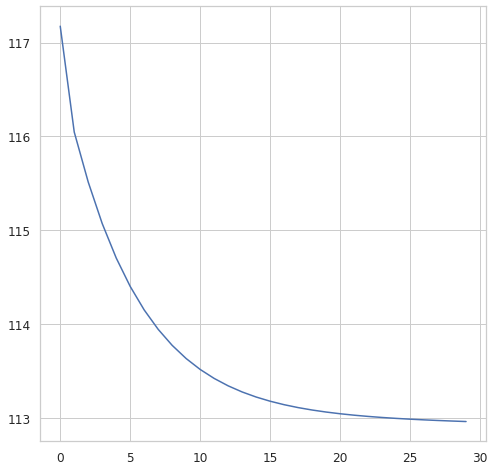

In [11]:
fig = plt.figure(figsize=(8, 8))
sns.lineplot(x=np.arange(0, epochs), y=epoch_train_loss)
fig.show()

Representing latitude and longitude as floating-point values does not have much predictive power. For example, neighborhoods at latitude 35 are not 36/35 more valuable (or 35/36 less valuable) than houses at latitude 36.

Representing `latitude` and `longitude` as floating-point values provides almost no predictive power. We're only using the raw values to establish a baseline for future experiments with better representations.

### Represent latitude and longitude in buckets
The following code cell represents latitude and longitude in buckets (bins). Each bin represents all the neighborhoods within a single degree. For example,
neighborhoods at latitude 35.4 and 35.8 are in the same bucket, but neighborhoods in latitude 35.4 and 36.2 are in different buckets. 

The model will learn a separate weight for each bucket. For example, the model will learn one weight for all the neighborhoods in the `35` bin, a different weight for neighborhoods in the `36` bin, and so on. This representation will create approximately 20 buckets: 10 buckets for `latitude` and 10 buckets for `longitude`.

In [12]:
latitude_enc, longtitude_enc = OrdinalEncoder(), OrdinalEncoder()

shuffled_train_df["latitude_bin"] = latitude_enc.fit_transform(shuffled_train_df["latitude"].astype(np.int).to_numpy().reshape(-1, 1))
shuffled_train_df["longitude_bin"] = longtitude_enc.fit_transform(shuffled_train_df["longitude"].astype(np.int).to_numpy().reshape(-1, 1))

test_df["latitude_bin"] = latitude_enc.transform(test_df["latitude"].astype(np.int).to_numpy().reshape(-1, 1))
test_df["longitude_bin"] = longtitude_enc.transform(test_df["longitude"].astype(np.int).to_numpy().reshape(-1, 1))

In [13]:
class BinnedLocationDataset(Dataset):
    def __init__(self, df, x_name, y_name):
        self.x = torch.tensor(df[x_name].astype(int).to_numpy().reshape(-1, len(x_name)))
        self.x = nn.functional.one_hot(self.x)  # one-hot encode each feature
        self.x = self.x.reshape(self.x.shape[0], -1).float()  # flatten multiple features into one matrix
        self.y = torch.tensor(df[y_name].to_numpy().reshape(-1, 1), dtype=torch.float)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
    def __len__(self):
        return len(self.y)
    

dat = BinnedLocationDataset(shuffled_train_df, ["latitude_bin", "longitude_bin"], "median_house_value")
test_dat = BinnedLocationDataset(test_df, ["latitude_bin", "longitude_bin"], "median_house_value")

In [16]:
# Hyperparameters
learning_rate = 0.07
epochs = 35
batch_size = 100

# For now we use the entire dataset for training (no validation set)
torch.manual_seed(42)
model = LinearRegressionModel(dat.x.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)

train_ds, valid_ds = train_test_split(dat, test_size=0.2)
train_loader=DataLoader(train_ds,batch_size=10,shuffle=False)
valid_loader=DataLoader(valid_ds,batch_size=10,shuffle=False)

losses = []
# train_step = make_train_step(my_model, criterion, optimizer)

epoch_train_loss = []

epoch_valid_loss = []

for epoch in range(epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for x_batch, y_batch in Bar(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # print(X)
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        losses.append(loss.item())
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(math.sqrt(train_loss))
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    # Iterate the validation set by batches.
    for x_batch, y_batch in Bar(valid_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device) 
       
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append(math.sqrt(valid_loss))
        
    # Print the information.
    display(f"[ Epoch | {epoch + 1:03d}/{epochs:03d} ] \
          train_loss = {train_loss:.5f} root_mean_squared_error = {math.sqrt(train_loss):.5f}  | \
          valid_loss = {valid_loss:.5f} val_root_mean_squared_error = {math.sqrt(valid_loss):.5f}")

print("Defined the build_model and train_model functions.")

test_loader = DataLoader(dataset=test_dat, batch_size=batch_size)
test_losses = []
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        y_hat = model(x_test)
        loss = criterion(y_hat, y_test)
        test_losses.append(loss.item())
    
print(f"Test set loss: {np.mean(test_losses):.4f}")
print(model.state_dict())

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 001/035 ]           train_loss = 23099.14336 root_mean_squared_error = 151.98402  |           valid_loss = 11751.67068 val_root_mean_squared_error = 108.40512'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 002/035 ]           train_loss = 10781.64113 root_mean_squared_error = 103.83468  |           valid_loss = 10816.98657 val_root_mean_squared_error = 104.00474'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 003/035 ]           train_loss = 10476.17906 root_mean_squared_error = 102.35321  |           valid_loss = 10717.70855 val_root_mean_squared_error = 103.52637'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 004/035 ]           train_loss = 10408.83993 root_mean_squared_error = 102.02372  |           valid_loss = 10668.03774 val_root_mean_squared_error = 103.28619'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 005/035 ]           train_loss = 10364.05295 root_mean_squared_error = 101.80399  |           valid_loss = 10629.46843 val_root_mean_squared_error = 103.09931'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 006/035 ]           train_loss = 10327.02638 root_mean_squared_error = 101.62198  |           valid_loss = 10596.67958 val_root_mean_squared_error = 102.94017'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 007/035 ]           train_loss = 10294.86116 root_mean_squared_error = 101.46360  |           valid_loss = 10568.01619 val_root_mean_squared_error = 102.80086'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 008/035 ]           train_loss = 10266.33491 root_mean_squared_error = 101.32292  |           valid_loss = 10542.63548 val_root_mean_squared_error = 102.67734'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 009/035 ]           train_loss = 10240.75750 root_mean_squared_error = 101.19663  |           valid_loss = 10520.00964 val_root_mean_squared_error = 102.56710'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 010/035 ]           train_loss = 10217.68714 root_mean_squared_error = 101.08258  |           valid_loss = 10499.76839 val_root_mean_squared_error = 102.46838'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 011/035 ]           train_loss = 10196.80906 root_mean_squared_error = 100.97925  |           valid_loss = 10481.63002 val_root_mean_squared_error = 102.37983'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 012/035 ]           train_loss = 10177.88191 root_mean_squared_error = 100.88549  |           valid_loss = 10465.36854 val_root_mean_squared_error = 102.30038'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 013/035 ]           train_loss = 10160.70859 root_mean_squared_error = 100.80034  |           valid_loss = 10450.79616 val_root_mean_squared_error = 102.22914'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 014/035 ]           train_loss = 10145.12187 root_mean_squared_error = 100.72300  |           valid_loss = 10437.75398 val_root_mean_squared_error = 102.16533'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 015/035 ]           train_loss = 10130.97573 root_mean_squared_error = 100.65275  |           valid_loss = 10426.10059 val_root_mean_squared_error = 102.10828'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 016/035 ]           train_loss = 10118.13988 root_mean_squared_error = 100.58896  |           valid_loss = 10415.70703 val_root_mean_squared_error = 102.05737'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 017/035 ]           train_loss = 10106.49481 root_mean_squared_error = 100.53106  |           valid_loss = 10406.45217 val_root_mean_squared_error = 102.01202'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 018/035 ]           train_loss = 10095.93022 root_mean_squared_error = 100.47851  |           valid_loss = 10398.21867 val_root_mean_squared_error = 101.97166'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 019/035 ]           train_loss = 10086.34352 root_mean_squared_error = 100.43079  |           valid_loss = 10390.89224 val_root_mean_squared_error = 101.93573'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 020/035 ]           train_loss = 10077.64079 root_mean_squared_error = 100.38745  |           valid_loss = 10384.37069 val_root_mean_squared_error = 101.90373'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 021/035 ]           train_loss = 10069.73790 root_mean_squared_error = 100.34808  |           valid_loss = 10378.56461 val_root_mean_squared_error = 101.87524'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 022/035 ]           train_loss = 10062.55943 root_mean_squared_error = 100.31231  |           valid_loss = 10373.39664 val_root_mean_squared_error = 101.84987'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 023/035 ]           train_loss = 10056.03783 root_mean_squared_error = 100.27980  |           valid_loss = 10368.79809 val_root_mean_squared_error = 101.82730'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 024/035 ]           train_loss = 10050.11338 root_mean_squared_error = 100.25025  |           valid_loss = 10364.71008 val_root_mean_squared_error = 101.80722'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 025/035 ]           train_loss = 10044.73079 root_mean_squared_error = 100.22340  |           valid_loss = 10361.07836 val_root_mean_squared_error = 101.78938'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 026/035 ]           train_loss = 10039.84078 root_mean_squared_error = 100.19901  |           valid_loss = 10357.85662 val_root_mean_squared_error = 101.77356'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 027/035 ]           train_loss = 10035.39860 root_mean_squared_error = 100.17684  |           valid_loss = 10355.00240 val_root_mean_squared_error = 101.75953'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 028/035 ]           train_loss = 10031.36348 root_mean_squared_error = 100.15669  |           valid_loss = 10352.47810 val_root_mean_squared_error = 101.74713'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 029/035 ]           train_loss = 10027.69842 root_mean_squared_error = 100.13840  |           valid_loss = 10350.24962 val_root_mean_squared_error = 101.73618'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 030/035 ]           train_loss = 10024.36964 root_mean_squared_error = 100.12177  |           valid_loss = 10348.28804 val_root_mean_squared_error = 101.72654'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 031/035 ]           train_loss = 10021.34668 root_mean_squared_error = 100.10668  |           valid_loss = 10346.56412 val_root_mean_squared_error = 101.71806'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 032/035 ]           train_loss = 10018.60127 root_mean_squared_error = 100.09296  |           valid_loss = 10345.05459 val_root_mean_squared_error = 101.71064'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 033/035 ]           train_loss = 10016.10868 root_mean_squared_error = 100.08051  |           valid_loss = 10343.73714 val_root_mean_squared_error = 101.70416'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 034/035 ]           train_loss = 10013.84547 root_mean_squared_error = 100.06920  |           valid_loss = 10342.59176 val_root_mean_squared_error = 101.69853'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 035/035 ]           train_loss = 10011.79089 root_mean_squared_error = 100.05894  |           valid_loss = 10341.59985 val_root_mean_squared_error = 101.69366'

Defined the build_model and train_model functions.
Test set loss: 9840.1058
OrderedDict([('linear.weight', tensor([[ 113.6960,  118.6275,  115.4835,   -7.8195,  -19.5214,   24.8341,
          -60.0801,  -92.7484, -145.0897, -153.8045,    0.1853,  134.0273,
          113.1096,  157.6373,  104.5099,   36.8405,   18.0833,   28.3487,
          -14.9350,  -75.1213, -138.9248, -152.1828]], device='cuda:0')), ('linear.bias', tensor([100.0020], device='cuda:0'))])


/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


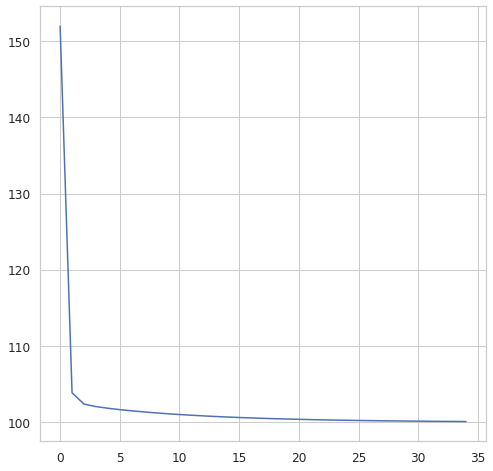

In [17]:
fig = plt.figure(figsize=(8, 8))
sns.lineplot(x=np.arange(0, epochs), y=epoch_train_loss)
fig.show()

Bucket representation outperformed floating-point representations (MSE ~13000 -> ~10000). However, you can still do far better.

### Represent location as a feature cross
Representing location as a feature cross should produce better results. We've represented latitude in one-dimensional buckets and longitude in another series of one-dimensional buckets. Real-world locations, however, exist in two dimensions. Therefore, you should represent location as a two-dimensional feature cross. That is, you'll cross the 10 or so latitude buckets with the 10 or so longitude buckets to create a grid of 100 cells. The model will learn separate weights for each of the cells.

In [18]:
def get_bins(x, step):
    x_min, x_max = int(np.min(x)), int(np.max(x))
    return np.linspace(x_min, x_max, int((x_max-x_min)/step)+1)

def bin_feature(enc, x, bins, fit=True):
    x_binned = pd.cut(x, bins).astype(str).to_numpy().reshape(-1, 1)
    if fit:
        enc.fit(x_binned)
    return enc.transform(x_binned)

In [19]:
class CrossBinnedLocationDataset(Dataset):
    def __init__(self, x1, x2, y):
        x1 = torch.tensor(x1.astype(int).to_numpy())
        x2 = torch.tensor(x2.astype(int).to_numpy())
        
        # one-hot encode each feature
        x1 = nn.functional.one_hot(x1)
        x2 = nn.functional.one_hot(x2)
        
        # cross the two tensors
        self.x = torch.tensor(np.einsum("...i,...j", x1, x2).reshape(x1.shape[0], -1)).float()
        self.y = torch.tensor(y.to_numpy().reshape(-1, 1), dtype=torch.float)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
    def __len__(self):
        return len(self.y)

In [20]:
resolution_in_degrees = 1.0
learning_rate = 0.04
epochs = 35

In [23]:
# Bin features
latitude_enc, longtitude_enc = OrdinalEncoder(), OrdinalEncoder()

latitude_bins = get_bins(shuffled_train_df["latitude"], resolution_in_degrees)
longitude_bins = get_bins(shuffled_train_df["longitude"], resolution_in_degrees)

shuffled_train_df["latitude_bin"] = bin_feature(latitude_enc, shuffled_train_df["latitude"], latitude_bins)
shuffled_train_df["longitude_bin"] = bin_feature(longtitude_enc, shuffled_train_df["longitude"], longitude_bins)
test_df["latitude_bin"] = bin_feature(latitude_enc, test_df["latitude"], latitude_bins, fit=False)
test_df["longitude_bin"] = bin_feature(longtitude_enc, test_df["longitude"], longitude_bins, fit=False)

# Cross features and convert to Dataset
dat = CrossBinnedLocationDataset(shuffled_train_df["latitude_bin"], shuffled_train_df["longitude_bin"], shuffled_train_df["median_house_value"])
test_dat = CrossBinnedLocationDataset(test_df["latitude_bin"], test_df["longitude_bin"], test_df["median_house_value"])

torch.manual_seed(42)
model = LinearRegressionModel(dat.x.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)

train_ds, valid_ds = train_test_split(dat, test_size=0.2)
train_loader=DataLoader(train_ds,batch_size=10,shuffle=False)
valid_loader=DataLoader(valid_ds,batch_size=10,shuffle=False)

losses = []
# train_step = make_train_step(my_model, criterion, optimizer)

epoch_train_loss = []

epoch_valid_loss = []

for epoch in range(epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for x_batch, y_batch in Bar(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # print(X)
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        losses.append(loss.item())
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(math.sqrt(train_loss))
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    # Iterate the validation set by batches.
    for x_batch, y_batch in Bar(valid_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device) 
       
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append(math.sqrt(valid_loss))
        
    # Print the information.
    display(f"[ Epoch | {epoch + 1:03d}/{epochs:03d} ] \
          train_loss = {train_loss:.5f} root_mean_squared_error = {math.sqrt(train_loss):.5f}  | \
          valid_loss = {valid_loss:.5f} val_root_mean_squared_error = {math.sqrt(valid_loss):.5f}")

print("Defined the build_model and train_model functions.")

test_loader = DataLoader(dataset=test_dat, batch_size=batch_size)
test_losses = []
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        y_hat = model(x_test)
        loss = criterion(y_hat, y_test)
        test_losses.append(loss.item())
    
print(f"Test set loss: {np.mean(test_losses):.4f}")
print(model.state_dict())

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 001/035 ]           train_loss = 38583.42012 root_mean_squared_error = 196.42663  |           valid_loss = 26402.67203 val_root_mean_squared_error = 162.48899'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 002/035 ]           train_loss = 19005.91442 root_mean_squared_error = 137.86194  |           valid_loss = 13533.33489 val_root_mean_squared_error = 116.33286'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 003/035 ]           train_loss = 11536.31356 root_mean_squared_error = 107.40723  |           valid_loss = 10208.69489 val_root_mean_squared_error = 101.03809'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 004/035 ]           train_loss = 10046.70469 root_mean_squared_error = 100.23325  |           valid_loss = 9658.81178 val_root_mean_squared_error = 98.27925'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 005/035 ]           train_loss = 9702.32849 root_mean_squared_error = 98.50040  |           valid_loss = 9459.49480 val_root_mean_squared_error = 97.25993'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 006/035 ]           train_loss = 9552.78962 root_mean_squared_error = 97.73837  |           valid_loss = 9367.13098 val_root_mean_squared_error = 96.78394'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 007/035 ]           train_loss = 9476.98440 root_mean_squared_error = 97.34980  |           valid_loss = 9319.22320 val_root_mean_squared_error = 96.53612'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 008/035 ]           train_loss = 9434.14052 root_mean_squared_error = 97.12950  |           valid_loss = 9292.23311 val_root_mean_squared_error = 96.39623'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 009/035 ]           train_loss = 9407.98615 root_mean_squared_error = 96.99477  |           valid_loss = 9276.19185 val_root_mean_squared_error = 96.31299'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 010/035 ]           train_loss = 9391.07024 root_mean_squared_error = 96.90753  |           valid_loss = 9266.23633 val_root_mean_squared_error = 96.26129'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 011/035 ]           train_loss = 9379.56142 root_mean_squared_error = 96.84814  |           valid_loss = 9259.78527 val_root_mean_squared_error = 96.22778'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 012/035 ]           train_loss = 9371.36612 root_mean_squared_error = 96.80582  |           valid_loss = 9255.40964 val_root_mean_squared_error = 96.20504'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 013/035 ]           train_loss = 9365.29694 root_mean_squared_error = 96.77446  |           valid_loss = 9252.30460 val_root_mean_squared_error = 96.18890'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 014/035 ]           train_loss = 9360.65900 root_mean_squared_error = 96.75050  |           valid_loss = 9250.01318 val_root_mean_squared_error = 96.17699'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 015/035 ]           train_loss = 9357.03143 root_mean_squared_error = 96.73175  |           valid_loss = 9248.27023 val_root_mean_squared_error = 96.16793'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 016/035 ]           train_loss = 9354.14695 root_mean_squared_error = 96.71684  |           valid_loss = 9246.91689 val_root_mean_squared_error = 96.16089'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 017/035 ]           train_loss = 9351.82658 root_mean_squared_error = 96.70484  |           valid_loss = 9245.85104 val_root_mean_squared_error = 96.15535'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 018/035 ]           train_loss = 9349.94258 root_mean_squared_error = 96.69510  |           valid_loss = 9245.00300 val_root_mean_squared_error = 96.15094'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 019/035 ]           train_loss = 9348.40005 root_mean_squared_error = 96.68712  |           valid_loss = 9244.32313 val_root_mean_squared_error = 96.14740'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 020/035 ]           train_loss = 9347.12739 root_mean_squared_error = 96.68054  |           valid_loss = 9243.77359 val_root_mean_squared_error = 96.14455'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 021/035 ]           train_loss = 9346.06842 root_mean_squared_error = 96.67507  |           valid_loss = 9243.32414 val_root_mean_squared_error = 96.14221'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 022/035 ]           train_loss = 9345.17639 root_mean_squared_error = 96.67045  |           valid_loss = 9242.94961 val_root_mean_squared_error = 96.14026'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 023/035 ]           train_loss = 9344.41531 root_mean_squared_error = 96.66652  |           valid_loss = 9242.62953 val_root_mean_squared_error = 96.13860'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 024/035 ]           train_loss = 9343.75734 root_mean_squared_error = 96.66311  |           valid_loss = 9242.34867 val_root_mean_squared_error = 96.13713'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 025/035 ]           train_loss = 9343.18233 root_mean_squared_error = 96.66014  |           valid_loss = 9242.09550 val_root_mean_squared_error = 96.13582'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 026/035 ]           train_loss = 9342.67477 root_mean_squared_error = 96.65751  |           valid_loss = 9241.86306 val_root_mean_squared_error = 96.13461'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 027/035 ]           train_loss = 9342.22346 root_mean_squared_error = 96.65518  |           valid_loss = 9241.64616 val_root_mean_squared_error = 96.13348'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 028/035 ]           train_loss = 9341.81879 root_mean_squared_error = 96.65308  |           valid_loss = 9241.44101 val_root_mean_squared_error = 96.13241'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 029/035 ]           train_loss = 9341.45372 root_mean_squared_error = 96.65120  |           valid_loss = 9241.24552 val_root_mean_squared_error = 96.13140'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 030/035 ]           train_loss = 9341.12269 root_mean_squared_error = 96.64948  |           valid_loss = 9241.05791 val_root_mean_squared_error = 96.13042'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 031/035 ]           train_loss = 9340.82098 root_mean_squared_error = 96.64792  |           valid_loss = 9240.87791 val_root_mean_squared_error = 96.12949'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 032/035 ]           train_loss = 9340.54716 root_mean_squared_error = 96.64651  |           valid_loss = 9240.70651 val_root_mean_squared_error = 96.12859'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 033/035 ]           train_loss = 9340.29854 root_mean_squared_error = 96.64522  |           valid_loss = 9240.54378 val_root_mean_squared_error = 96.12775'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 034/035 ]           train_loss = 9340.06911 root_mean_squared_error = 96.64403  |           valid_loss = 9240.38599 val_root_mean_squared_error = 96.12693'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 035/035 ]           train_loss = 9339.85512 root_mean_squared_error = 96.64293  |           valid_loss = 9240.23185 val_root_mean_squared_error = 96.12612'

Defined the build_model and train_model functions.
Test set loss: 9072.7406
OrderedDict([('linear.weight', tensor([[-3.8986e+01, -6.7009e+01,  2.8242e+01,  4.5928e+01, -2.0891e-02,
          1.9240e-02, -4.6420e-02,  5.5995e-02,  8.4052e-02, -6.9949e-02,
          8.2875e-02, -7.7143e+01, -8.9583e+01, -1.8973e+01,  8.5910e+01,
          7.3540e+01,  7.3501e-02,  1.4093e-02, -4.4511e-02,  2.4304e-02,
         -4.3930e-02, -1.1182e-02, -7.2878e+01, -3.9977e+01, -5.6464e+01,
         -6.4431e-01,  1.1598e+02,  1.2753e+02,  2.2881e+01, -9.4172e-02,
          8.6108e-02, -8.0994e-02,  7.3610e-02,  1.5867e-02, -1.3231e+01,
         -2.5577e+01, -6.1644e+01, -7.7040e+01, -6.9594e+01,  6.7917e+01,
          1.5130e+01, -2.5856e-02,  4.0127e-02,  8.5127e-02,  5.5116e-02,
         -4.1683e-02,  5.5040e-02, -1.3983e+01, -5.8100e+01, -6.5159e+01,
         -8.0694e+01,  8.4601e+01,  1.0052e+02,  7.8235e-02,  2.7463e-02,
          3.9494e-02,  3.0154e-02, -1.6586e-03,  7.4619e-02,  1.6970e+00,
     

/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


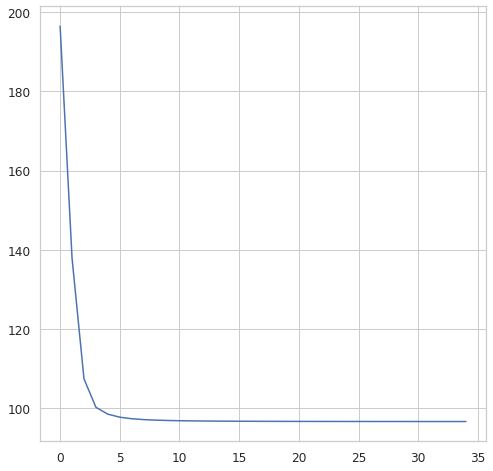

In [24]:
fig = plt.figure(figsize=(8, 8))
sns.lineplot(x=np.arange(0, epochs), y=epoch_train_loss)
fig.show()

representing these features as a feature cross produced much lower loss values than representing these features as buckets (MSE ~10000 -> ~9000). 

Return to the code cell in the "Represent location as a feature cross" section. Notice that `resolution_in_degrees` is set to 1.0. Therefore, each cell represents an area of 1.0 degree of latitude by 1.0 degree of longitude, which corresponds to a cell of 110 km by 90 km.  This resolution defines a rather large neighborhood. 

Experiment with `resolution_in_degrees` to answer the following questions:

1. What value of `resolution_in_degrees` produces the best results (lowest loss value)?
2. Why does loss increase when the value of `resolution_in_degrees` drops below a certain value?

Finally, answer the following question:

3. What feature (that does not exist in the California Housing Dataset) would
     be a better proxy for location than latitude X longitude.
     
Answers:
1. A resolution of ~0.4 degree provides the best results.
2. Below ~0.4 degree, loss increases because the dataset does not contain enough examples in each cell to accurately predict prices for those cells.
3. Postal code would be a far better feature than latitude X longitude, assuming that the dataset contained sufficient examples in each postal code.